# Import

In [1]:
import fpmodules as fp
import pandas as pd
from evex_scout import *
from fpmodules.tools.constants import EVENTS_CACHE_PATH
from fpmodules.plotting import load_data_from_files
from fpmodules.tools.dbtools import to_pdatime
from fpmodules import BlobManager
import matplotlib.pyplot as plt
import fpmodules.tools as tools

*** FP-modules version 2.10.9 ***


# Constants

In [2]:
RAWDATA_CACHE_PATH = os.path.join(EVENTS_CACHE_PATH, 'RawData')

SNR = 10
window_res = 10
step_interval = 1
window_size = 2
erosion_mask_length = 10
expand_dist = 0
hard_threshold = 5
saturation_threshold = 30000

# {1: "C", 2: "B", 3: "A", 4: "D"}
channels = [1, 1, 2, 2, 3, 3, 4, 4]
colors = tools.get_instrument_info()['Scout']['cmap']
tools.get_instrument_info()

{'SRS': {'channels': [808, 975]},
 'Scout': {'channels': ['970C',
   '810C',
   '970B',
   '810B',
   '970A',
   '810A',
   '970D',
   '810D'],
  'cmap': ['#0000F1',
   '#1E90FF',
   '#008040',
   '#20D100',
   '#F40000',
   '#F78528',
   '#481F01',
   '#957439'],
  'legend_img_path': 'SCOUT colour scheme skew.png'}}

# Get data

In [3]:
fp.get_session(sessionid=686)

,SessionId,StartTimeId,StartDateId,EndTimeId,EndDateId,UnitId,SubjectCompositionId,Name,SubscriptionId,MacAddress
0,686,151747,20210330,92009,20210419,18,149,Apis mellifera - Labelled - Taastrup transp.,15,dca6327d8fa8


In [4]:
measurements = fp.dbquery('select * from measurement where sessionid=686')
measurements = measurements.sort_values('TimeId')
measurements = to_pdatime(measurements, delete=False)
measurements.head()

,Id,TimeId,DateId,MeasurementCode,UnitId,SessionId,Datetime
22628,37084806,37,20210407,338cc921621f7c00,18,686,2021-04-07 00:00:37
21552,37084824,557,20210407,6810ed6acf8ac800,18,686,2021-04-07 00:05:57
21553,37084825,558,20210407,77da2bf1d1dd7800,18,686,2021-04-07 00:05:58
4535,35434703,738,20210331,337f99c1e6771200,18,686,2021-03-31 00:07:38
25819,37993474,743,20210409,1d9514966ede0700,18,686,2021-04-09 00:07:43


In [5]:
insects = fp.get_insects(sessionid=686, all_segments=True)
insects.head()

,Classification,SegmentId,ClassifierId,MeasurementId,MeasurementCode,SessionId,UnitId,Datetime
0,1.0,1,31,35422373,2664d5f7559b6a00,686,18,2021-03-30 16:16:55
1,1.0,3,31,35422373,2664d5f7559b6a00,686,18,2021-03-30 16:16:55
2,1.0,4,31,35422373,2664d5f7559b6a00,686,18,2021-03-30 16:16:55
3,1.0,2,31,35422373,2664d5f7559b6a00,686,18,2021-03-30 16:16:55
4,1.0,1,31,35422376,26fa83698dfe9800,686,18,2021-03-30 16:16:52


# Define functions

In [6]:
def get_start_and_stop(data, times):
    fss = get_samplerates(times)
    fs = int(np.median(fss))
    data_matrix = data.copy() # transpose
    data_matrix, medians, stds, interp = remove_rolling_mean(data_matrix.astype(int), fs, window_res=window_res, step_interval=step_interval, window_size=window_size)
    event_mask_master = threshold(data_matrix, stds, interp, SNR=SNR, erosion_mask=np.ones(erosion_mask_length), expand_dist=expand_dist, hard_threshold=hard_threshold)
    start_inds, stop_inds = label_events(event_mask_master)

    return start_inds, stop_inds

def get_seconds(event):
    dt = event.info['Datetime']
    seconds = int(dt.strftime('%s'))
    return seconds

In [7]:
def create_labelled_data(blob):
    file_list = blob_mgr.download_blobs([blob], RAWDATA_CACHE_PATH, container='scouts')
    data, times = load_data_from_files(file_list, path, ds=1)
    if len(data) == 0:
        return

    raw_start = pd.Timestamp(datetime.datetime.utcfromtimestamp(int(times[0])))
    raw_end = pd.Timestamp(datetime.datetime.utcfromtimestamp(int(times[-1])))
    print('raw_start:', raw_start)
    print('raw_end:', raw_end)

    in_range = (measurements['Datetime'] >= raw_start) & (measurements['Datetime'] <= raw_end)
    _meas = measurements[in_range]

    if len(_meas) == 0:
        # no measurements found in time range
        print('Found no measurements in range, continuing...')
        return
    print(f'Found {len(_meas)} measurements')

    print('Running event extraction')
    start_inds, stop_inds = get_start_and_stop(data, times)
    labels = np.zeros_like(data)

    if (len(start_inds) == 0) & (len(stop_inds) == 0):
        return

    for i, m_id in enumerate(_meas['Id'].tolist()):
        if m_id in insects['MeasurementId'].tolist():
            _insects = insects[insects['MeasurementId'] == m_id]

            for c in range(0,8):
                if (channels[c] in _insects['SegmentId'].tolist()):
                    labels[start_inds[i]:stop_inds[i],c] = 1

    filename = blob.replace('/', '_').split('.')[0] + '_ds_5'
    event_path = os.path.join(EVENTS_CACHE_PATH, 'RawLabelledData')
    with open(event_path + '/' + filename + '_data.npy', 'wb') as f:
        np.save(f, data[::5,:])
    with open(event_path + '/' + filename + '_labels.npy', 'wb') as f:
        np.save(f, labels[::5,:])
    return data, times, labels, start_inds, stop_inds, _meas

# Find blobs

In [8]:
mac = 'dca6327d8fa8'
path=RAWDATA_CACHE_PATH
blob_mgr = BlobManager(configuration='rclone')

In [9]:
date = 20210330
blob_list = blob_mgr.list_blobs(container='scouts', subdir=f"{mac}/{str(date)}/raw/")
blob_list = [b for b in blob_list if b.endswith(".raw.gz")]
print('Number of raw data files:', len(blob_list))

Number of raw data files: 115


# Test and visualize

In [10]:
date = 20210330

blob_list = blob_mgr.list_blobs(container='scouts', subdir=f"{mac}/{str(date)}/raw/")
blob_list = [b for b in blob_list if b.endswith(".raw.gz")]
print('Number of raw data files:', len(blob_list))

Number of raw data files: 115


In [11]:
for blob in blob_list[75:76]:
    data, times, labels, start_inds, stop_inds, _meas = create_labelled_data(blob)

Some files exist, not downloading again.
100% complete      [==================================================]

Reading dca6327d8fa8_20210330_raw_20210330T152242Z.raw.gz 1 of 1
raw_start: 2021-03-30 15:23:08
raw_end: 2021-03-30 15:33:03
Found 65 measurements
Running event extraction


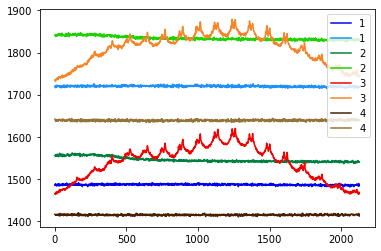

In [12]:
for c in range(0,8):
    plt.plot(data[start_inds[0]:stop_inds[0],c], label=str(channels[c]), color=colors[c])
plt.legend()

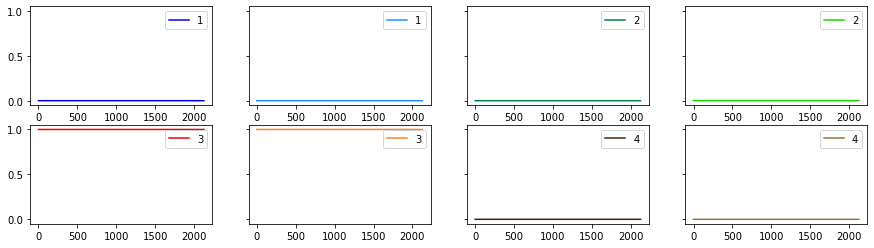

In [13]:
ax = [None]*8
fig, ((ax[0], ax[1], ax[2], ax[3]), (ax[4], ax[5], ax[6], ax[7])) = plt.subplots(nrows=2, ncols=4, sharey=True)
fig.set_figwidth(15)
for c in range(0,8):
    ax[c].plot(labels[start_inds[0]:stop_inds[0],c], label=str(channels[c]), color=colors[c])
    ax[c].legend()
plt.show()

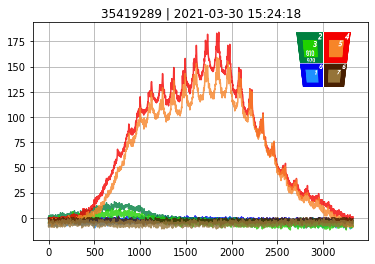

In [14]:
for m_id in _meas['Id'].tolist()[0:1]:
    event = fp.Event(m_id).fill()
    event.plot()
    plt.show()

# Run for all - THIS WILL TAKE A WHILE

In [15]:
if False:
    for blob in blob_list:
        data, times, labels = create_labelled_data(blob)

# Run for all dates - THIS WILL TAKE FOREVER

In [16]:
if False:
    dates = measurements['DateId'].unique().tolist()
    for date in dates:
        path=RAWDATA_CACHE_PATH
        blob_mgr = BlobManager(configuration='rclone')
        blob_list = blob_mgr.list_blobs(container='scouts', subdir=f"{mac}/{str(date)}/raw/")
        blob_list = [b for b in blob_list if b.endswith(".raw.gz")]
        print('Number of raw data files:', len(blob_list))

        for blob in blob_list:
            data, times, labels, start_inds, stop_inds, _meas = create_labelled_data(blob)